# First time data processing

Divide the images files to sub-directories for each class to enable the `tensorflow.data` api to interact with them  

In [ ]:
# import os
# os.environ['KAGGLE_USERNAME'] = "aymanmostafa11"
# os.environ['KAGGLE_KEY'] = "9e906ab1e07a4dc6e797063cf8a37f32"
# !kaggle competitions download -c nn23-sports-image-classification

 99% 258M/262M [00:08<00:00, 41.5MB/s]
100% 262M/262M [00:08<00:00, 33.1MB/s]


In [ ]:
# !unzip "/content/nn23-sports-image-classification.zip" -d "/content/data"

In [ ]:
# import shutil
# import glob
# sports = ["Basketball", "Football", "Rowing", "Swimming", "Tennis", "Yoga"]
# files = {sport: glob.glob("/content/data/Train/" + sport + "*") for sport in sports}
# for sport in files:
#   try:
#     print("makin dir")
#     os.mkdir("/content/classed/Train/" + sport + "/")
#   except:
#     pass
#   names = files[sport]
#   for f in names:
#     shutil.move(f, "/content/classed/Train/" + sport + "/")

makin dir
makin dir
makin dir
makin dir
makin dir
makin dir


In [ ]:
# shutil.move("/content/data/Test", "/content/classed")

'/content/classed/Test'

In [ ]:
# !zip -r "dataset.zip" "/content/classed/"

In [ ]:
# !cp "dataset.zip" "/content/drive/MyDrive/Edu/NN/ProjectData"

# Models

## Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras import layers
import cv2
from google.colab.patches import cv2_imshow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, SeparableConv2D, ReLU, BatchNormalization, \
    Add

from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Check for gpu availability
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  1


## Global Params

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
COLOR_MODE = "rgb"
COLOR_CHANNELS = 3 if COLOR_MODE == "rgb" else 1
SEED = 42
VALIDATION_SPLIT = 0.2
sports = ["Basketball", "Football", "Rowing", "Swimming", "Tennis", "Yoga"]
CLASS_COUNT = len(sports)

## Util functions

In [ ]:
def get_data_labels(data):
  _ , labels = zip((*data))
  labels = np.hstack(labels)
  del _
  return labels.T

In [ ]:
def show_confusion_matrix(model, data):
  imgs, labels = zip((*data))
  imgs = np.vstack(imgs)
  labels = np.hstack(labels)
  preds = model.predict(imgs).argmax(axis=1)
  ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=sports, xticks_rotation=45)
  del imgs
  del labels

In [ ]:
def calc_f1_score(model, data):
  imgs, labels = zip((*data))
  imgs = np.vstack(imgs)
  labels = np.hstack(labels)
  preds = model.predict(imgs).argmax(axis=1)
  score = f1_score(labels, preds, average='weighted')
  del imgs
  del labels
  return score

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unzip "/content/drive/MyDrive/Edu/NN/ProjectData/dataset.zip" -d "/content/"

In [ ]:
train_path = "/content/content/classed/Train"
test_path =  "/content/content/classed/Test"

In [ ]:
train_data = utils.image_dataset_from_directory(train_path,subset='training' ,
                                                class_names = sports,
                                                validation_split=VALIDATION_SPLIT, 
                                                seed = SEED, 
                                                image_size=IMG_SIZE, 
                                                batch_size=BATCH_SIZE,
                                                color_mode=COLOR_MODE)

valid_data = utils.image_dataset_from_directory(train_path,subset='validation',
                                           class_names= sports,
                                           validation_split=VALIDATION_SPLIT,
                                           seed = SEED, 
                                           image_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE,
                                           color_mode=COLOR_MODE) 
total_data =  utils.image_dataset_from_directory(train_path,
                                           class_names= sports,
                                           image_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE,
                                           color_mode=COLOR_MODE) 

Found 1681 files belonging to 6 classes.
Using 1345 files for training.
Found 1681 files belonging to 6 classes.
Using 336 files for validation.
Found 1681 files belonging to 6 classes.


In [ ]:
valid_labels = get_data_labels(valid_data) # will be used in building confusion matrix

In [ ]:
test_data = utils.image_dataset_from_directory(test_path,
                                               label_mode=None, 
                                               seed = SEED, 
                                               image_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE,
                                               color_mode=COLOR_MODE, 
                                               shuffle=False)

Found 688 files belonging to 1 classes.


### Augmentation

In [ ]:
def augment_data(train_data):
  augmentor_1 = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.1,0.1)
  ])

  # augmentor_2 = tf.keras.Sequential([
  #   layers.RandomContrast(0.2),
  #   layers.RandomBrightness(0.2)
  # ])

  aug_data_1 = train_data.map(lambda x, y: (augmentor_1(x, training=True), y))
  # aug_data_2 = train_data.map(lambda x, y: (augmentor_2(x, training=True), y))

  # aug_data = aug_data_1.concatenate(aug_data_2)
  return aug_data_1

In [ ]:
aug_data = augment_data(train_data)

In [ ]:
train_data = train_data.concatenate(aug_data)

In [ ]:
train_data = train_data.shuffle(6000)

In [ ]:
#train_data = train_data.batch(32)

In [ ]:
# Should be 44 (22 batches for main data + 22 batche for aug data)
train_data.cardinality().numpy()

44

## Tuning functions

<h3>Weight decay (Regularization)</h3>

In [ ]:
def apply_weight_decay(model, alpha=0.002):
  for layer in model.layers:
      if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
          layer.add_loss(lambda layer=layer: keras.regularizers.l2(alpha)(layer.kernel))
      if hasattr(layer, 'bias_regularizer') and layer.use_bias:
          layer.add_loss(lambda layer=layer: keras.regularizers.l2(alpha)(layer.bias))

<h3>Class weights</h3>

Since classes are imbalanced we need the model to give higher weights to classes that appear less in data

In [ ]:
def get_class_weights(data):
  _ , train_labels = zip((*data))
  train_labels = np.hstack(train_labels)
  w = compute_class_weight('balanced',classes=np.unique(train_labels),y=train_labels)
  class_weights = {i:w[i] for i in range(len(sports))}
  del _
  del train_labels
  return class_weights

In [ ]:
class_weight = get_class_weights(train_data)

In [ ]:
# l = get_data_labels(train_data)
# label_counts = pd.Series(l).value_counts()
# label_counts.index = label_counts.index.map({i:sport for i,sport in enumerate(sports)})
# ax = sns.barplot(x=label_counts.index, y=label_counts.values)
# ax.set_title("Train data class distribution")
# ax.set_xlabel("Sport")
# ax.set_ylabel("Label Count")
# plt.show()

## CNN

In [ ]:
model = keras.Sequential()
#model.add(keras.layers.Rescaling(1 / 255.0, input_shape=(*IMG_SIZE, COLOR_CHANNELS)))

model.add(keras.layers.Conv2D(16, (5,5), strides=(2,2), activation='leaky_relu', input_shape=(*IMG_SIZE, COLOR_CHANNELS)))
model.add(layers.BatchNormalization())
model.add(keras.layers.Conv2D(16, (5,5),strides=(2,2) ,activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(32, (3,3), activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3,3), activation='leaky_relu'))
model.add(layers.BatchNormalization())
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, (3,3), activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (3,3), activation='leaky_relu'))
model.add(layers.BatchNormalization())
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.MaxPooling2D())


model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(32, activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(CLASS_COUNT, activation='softmax'))

In [ ]:
apply_weight_decay(model)

In [ ]:
model.compile(keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 110, 110, 16)      1216      
                                                                 
 batch_normalization_97 (Bat  (None, 110, 110, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_83 (Conv2D)          (None, 53, 53, 16)        6416      
                                                                 
 batch_normalization_98 (Bat  (None, 53, 53, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 26, 26, 16)       0         
 g2D)                                                            
                                                     

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("checkpoints/cnn-e{epoch:02d}-acc{val_accuracy:.2f}.hdf5",
                                                   monitor="val_accuracy",
                                                   save_best_only = True,
                                                   initial_value_threshold=0.85)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00001)

In [ ]:
model.fit(train_data, epochs=15, validation_data=valid_data, callbacks=[model_checkpoint, lr_reduction], class_weight=class_weight)

Epoch 1/15
22/22 [==============================] - 5s 188ms/step - loss: 0.9646 - accuracy: 0.8498 - val_loss: 1.3194 - val_accuracy: 0.7262 - lr: 1.0000e-04
Epoch 2/15
22/22 [==============================] - 5s 156ms/step - loss: 0.9034 - accuracy: 0.8699 - val_loss: 1.3463 - val_accuracy: 0.6994 - lr: 1.0000e-04
Epoch 3/15
22/22 [==============================] - 4s 154ms/step - loss: 0.9001 - accuracy: 0.8729 - val_loss: 1.2728 - val_accuracy: 0.7381 - lr: 1.0000e-04
Epoch 4/15
22/22 [==============================] - 5s 155ms/step - loss: 0.8728 - accuracy: 0.8736 - val_loss: 1.2144 - val_accuracy: 0.7560 - lr: 1.0000e-04
Epoch 5/15
22/22 [==============================] - 5s 158ms/step - loss: 0.8416 - accuracy: 0.8974 - val_loss: 1.2021 - val_accuracy: 0.7619 - lr: 1.0000e-04
Epoch 6/15
22/22 [==============================] - 5s 158ms/step - loss: 0.8187 - accuracy: 0.9093 - val_loss: 1.1937 - val_accuracy: 0.7619 - lr: 1.0000e-04
Epoch 7/15
22/22 [============================

6/6 [==============================] - 1s 27ms/step


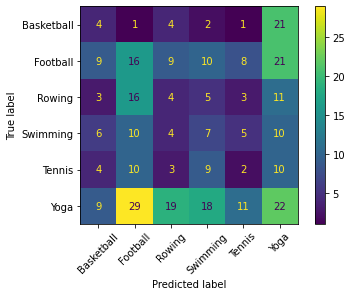

In [ ]:
show_confusion_matrix(model, valid_data, valid_labels)

## Inception

### Inception Module
The inception layer is the core layer in buiilding [Inception Architecture](https://towardsdatascience.com/deep-learning-understand-the-inception-module-56146866e652#:~:text=Happy%20Reading.-,Inception%20Network,details%20of%20the%20inception%20module.)

> *This code was adopted from [Deep Learning in the Trenches: Understanding Inception Network from Scratch](https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/)*

In [ ]:
alpha = 0.002
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='leaky_relu', 
                      kernel_regularizer=keras.regularizers.l2(alpha),
                      bias_regularizer=keras.regularizers.l2(alpha))(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='leaky_relu',
                      kernel_regularizer=keras.regularizers.l2(alpha),
                      bias_regularizer=keras.regularizers.l2(alpha))(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='leaky_relu',
                      kernel_regularizer=keras.regularizers.l2(alpha),
                      bias_regularizer=keras.regularizers.l2(alpha))(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='leaky_relu',
                      kernel_regularizer=keras.regularizers.l2(alpha),
                      bias_regularizer=keras.regularizers.l2(alpha))(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='leaky_relu',
                      kernel_regularizer=keras.regularizers.l2(alpha),
                      bias_regularizer=keras.regularizers.l2(alpha))(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='leaky_relu',
                      kernel_regularizer=keras.regularizers.l2(alpha),
                      bias_regularizer=keras.regularizers.l2(alpha))(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

### Network

#### Original Inception
The inception architecture proposed in *GoogLeNet* except that the `relu` activation has been replaced with `leaky_relu` to avoid [Dying Relu problem](https://towardsdatascience.com/the-dying-relu-problem-clearly-explained-42d0c54e0d24#0863)

In [ ]:
input_layer = Input(shape=(*IMG_SIZE, COLOR_CHANNELS))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='leaky_relu', name='conv_1_7x7/2')(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='leaky_relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='leaky_relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(CLASS_COUNT, activation='softmax', name='output')(x)

In [ ]:
orig_inception = Model(input_layer, x, name='inception_v1')

In [ ]:
orig_inception.compile(keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
orig_inception.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("checkpoints/orig_incep-e{epoch:02d}-acc{val_accuracy:.2f}.hdf5",
                                                   monitor="val_accuracy",
                                                   save_best_only = True,
                                                   initial_value_threshold=0.85)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00001)

In [ ]:
orig_inception.fit(train_data, epochs=2, validation_data=valid_data, callbacks=[model_checkpoint, lr_reduction])

Evaluating

6/6 [==============================] - 16s 2s/step


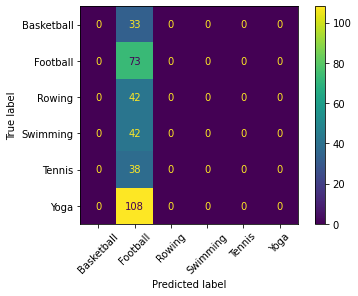

In [ ]:
show_confusion_matrix(orig_inception, valid_data, valid_labels)

#### Modified Architecture

In [ ]:
input_layer = Input(shape=(*IMG_SIZE, COLOR_CHANNELS))

x = Conv2D(16, (5, 5), padding='same', strides=(2, 2), activation='leaky_relu', name='conv_1_7x7/2')(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(32, (1, 1), padding='same', strides=(1, 1), activation='leaky_relu', name='conv_2a_3x3/1')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='leaky_relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=16,
                     filters_3x3_reduce=24,
                     filters_3x3=32,
                     filters_5x5_reduce=8,
                     filters_5x5=16,
                     filters_pool_proj=16,
                     name='inception_3a')

x = MaxPool2D((3, 3), padding='same', strides=(4, 4), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=32,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(32, activation='leaky_relu', name='dense_1')(x)

x = Dropout(0.2)(x)

x = Dense(CLASS_COUNT, activation='leaky_relu', name='output')(x)

modified_incep = keras.models.Model(input_layer, [x], name="inception")

In [ ]:
modified_incep = Model(input_layer, x, name='mini_inception')

In [ ]:
apply_weight_decay(modified_incep)

In [ ]:
modified_incep.compile(keras.optimizers.Adam(learning_rate=0.00005),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
modified_incep.summary()

Model: "mini_inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 16  1216        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 16)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                   

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("checkpoints/modified_incep-e{epoch:02d}-acc{val_accuracy:.2f}.hdf5",
                                                   monitor="val_accuracy",
                                                   save_best_only = True,
                                                   initial_value_threshold=0.85)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00001)

In [ ]:
modified_incep.fit(train_data, epochs=40, validation_data=valid_data, 
                   callbacks=[model_checkpoint, lr_reduction],
                   class_weight=class_weight)

Epoch 1/40
22/22 [==============================] - 5s 159ms/step - loss: 3.2257 - accuracy: 0.6565 - val_loss: 3.1023 - val_accuracy: 0.6875 - lr: 4.0000e-05
Epoch 2/40
22/22 [==============================] - 5s 156ms/step - loss: 3.2303 - accuracy: 0.6721 - val_loss: 3.0748 - val_accuracy: 0.7113 - lr: 4.0000e-05
Epoch 3/40
22/22 [==============================] - 5s 159ms/step - loss: 3.2167 - accuracy: 0.6461 - val_loss: 3.0126 - val_accuracy: 0.7381 - lr: 4.0000e-05
Epoch 4/40
22/22 [==============================] - 5s 159ms/step - loss: 3.2276 - accuracy: 0.6617 - val_loss: 3.1109 - val_accuracy: 0.6935 - lr: 4.0000e-05
Epoch 5/40
22/22 [==============================] - 5s 157ms/step - loss: 3.2314 - accuracy: 0.6513 - val_loss: 3.0337 - val_accuracy: 0.7202 - lr: 4.0000e-05
Epoch 6/40
22/22 [==============================] - 5s 159ms/step - loss: 3.1640 - accuracy: 0.6706 - val_loss: 3.0465 - val_accuracy: 0.7143 - lr: 4.0000e-05
Epoch 7/40
22/22 [============================

6/6 [==============================] - 1s 32ms/step


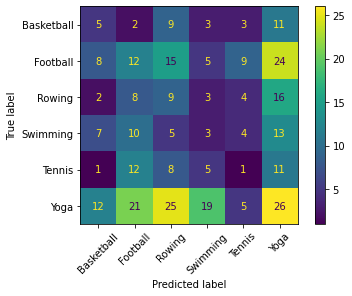

In [ ]:
show_confusion_matrix(modified_incep, valid_data, valid_labels)

## Resnet

In [ ]:

os.environ['KAGGLE_USERNAME'] = "aymanmostafa11"
os.environ['KAGGLE_KEY'] = "9e906ab1e07a4dc6e797063cf8a37f32"

In [ ]:
!kaggle datasets download -d keras/resnet50

 99% 173M/174M [00:01<00:00, 82.2MB/s]
100% 174M/174M [00:01<00:00, 115MB/s] 


In [ ]:
!unzip "resnet50.zip"

Archive:  resnet50.zip
  inflating: imagenet_class_index.json  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50((*IMG_SIZE, COLOR_CHANNELS))

In [ ]:
base_model.load_weights("/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
back_bone = base_model.output
new_layers = keras.layers.GlobalAveragePooling2D()(back_bone)
# new_layers = keras.layers.Dense(32, activation='leaky_relu')(new_layers)
new_layers = keras.layers.Dense(CLASS_COUNT, activation='softmax')(new_layers)

res_model = Model(inputs=base_model.inputs, outputs=new_layers)

In [ ]:
apply_weight_decay(res_model)

In [ ]:
res_model.compile(keras.optimizers.Adam(learning_rate=0.00005),
              loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# res_model.summary()

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("checkpoints/pretrained-res-e{epoch:02d}-acc{val_accuracy:.2f}.hdf5",
                                                   monitor="val_accuracy",
                                                   save_best_only = True,
                                                   initial_value_threshold=0.95)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00001)

In [ ]:
res_model.fit(train_data, epochs=5, validation_data=valid_data, 
                   callbacks=[model_checkpoint, lr_reduction],
                   class_weight=class_weight)

Epoch 1/5
22/22 [==============================] - 36s 908ms/step - loss: 23.7026 - accuracy: 0.8781 - val_loss: 23.2449 - val_accuracy: 0.9196 - lr: 5.0000e-05
Epoch 2/5
22/22 [==============================] - 18s 764ms/step - loss: 22.6424 - accuracy: 0.9993 - val_loss: 22.5162 - val_accuracy: 0.9256 - lr: 5.0000e-05
Epoch 3/5
22/22 [==============================] - 19s 792ms/step - loss: 21.9756 - accuracy: 0.9993 - val_loss: 21.9032 - val_accuracy: 0.9286 - lr: 5.0000e-05
Epoch 4/5
22/22 [==============================] - 18s 769ms/step - loss: 21.3425 - accuracy: 0.9993 - val_loss: 21.2941 - val_accuracy: 0.9315 - lr: 5.0000e-05
Epoch 5/5
22/22 [==============================] - 18s 766ms/step - loss: 20.8111 - accuracy: 0.9978 - val_loss: 20.8855 - val_accuracy: 0.8988 - lr: 5.0000e-05


In [ ]:
calc_f1_score(res_model, valid_data)

11/11 [==============================] - 2s 102ms/step


0.9551154239299797

11/11 [==============================] - 1s 102ms/step


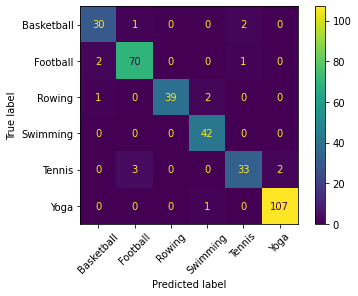

In [ ]:
show_confusion_matrix(res_model, valid_data)

## Xception

In [ ]:
# Download weights
xception_weights = "xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
!wget https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-12-24 16:30:22--  https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83683744 (80M) [application/octet-stream]
Saving to: ‘xception_weights_tf_dim_ordering_tf_kernels_notop.h5’

xception_weights_tf 100%[===================>]  79.81M  31.4MB/s    in 2.5s    

2022-12-24 16:30:25 (31.4 MB/s) - ‘xception_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [83683744/83683744]



### Architecture

In [ ]:
def conv_bn(x, filters, kernel_size, strides=1):
  
  x = Conv2D(filters=filters, 
              kernel_size = kernel_size, 
              strides=strides, 
              padding = 'same', 
              use_bias = False)(x)
  x = BatchNormalization(axis=COLOR_CHANNELS)(x)
  return x

In [ ]:
def sep_bn(x, filters, kernel_size, strides=1):
  
  x = SeparableConv2D(filters=filters, 
                      kernel_size = kernel_size, 
                      strides=strides, 
                      padding = 'same', 
                      use_bias = False)(x)
  x = BatchNormalization(axis=COLOR_CHANNELS)(x)
  return x

In [ ]:
def entry_flow(x):
    
  x = conv_bn(x, filters =32, kernel_size =3, strides=2)
  x = ReLU()(x)
  x = conv_bn(x, filters =64, kernel_size =3, strides=1)
  tensor = ReLU()(x)
  
  x = sep_bn(tensor, filters = 128, kernel_size =3)
  x = ReLU()(x)
  x = sep_bn(x, filters = 128, kernel_size =3)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
  
  tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
  x = Add()([tensor,x])
  
  x = ReLU()(x)
  x = sep_bn(x, filters =256, kernel_size=3)
  x = ReLU()(x)
  x = sep_bn(x, filters =256, kernel_size=3)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
  
  tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
  x = Add()([tensor,x])
  
  x = ReLU()(x)
  x = sep_bn(x, filters =728, kernel_size=3)
  x = ReLU()(x)
  x = sep_bn(x, filters =728, kernel_size=3)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
  
  tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
  x = Add()([tensor,x])
  return x

In [ ]:
def middle_flow(tensor):

  for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, filters = 728, kernel_size = 3)
      x = ReLU()(x)
      x = sep_bn(x, filters = 728, kernel_size = 3)
      x = ReLU()(x)
      x = sep_bn(x, filters = 728, kernel_size = 3)
      x = ReLU()(x)
      tensor = Add()([tensor,x])
      
  return tensor

In [ ]:
def exit_flow(tensor):
    
  x = ReLU()(tensor)
  x = sep_bn(x, filters = 728,  kernel_size=3)
  x = ReLU()(x)
  x = sep_bn(x, filters = 1024,  kernel_size=3)
  x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
  
  tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
  x = Add()([tensor,x])
  
  x = sep_bn(x, filters = 1536,  kernel_size=3)
  x = ReLU()(x)
  x = sep_bn(x, filters = 2048,  kernel_size=3)
  x = GlobalAveragePooling2D()(x)
  
#  x = Dense (units = 1000, activation = 'softmax')(x)
  
  return x

In [ ]:
channel_axis = 3 
img_input = Input(shape = (*IMG_SIZE, COLOR_CHANNELS))
x = layers.Conv2D(
    32, (3, 3), strides=(2, 2), use_bias=False, name="block1_conv1"
)(img_input)
x = layers.BatchNormalization(axis=channel_axis, name="block1_conv1_bn")(x)
x = layers.Activation("relu", name="block1_conv1_act")(x)
x = layers.Conv2D(64, (3, 3), use_bias=False, name="block1_conv2")(x)
x = layers.BatchNormalization(axis=channel_axis, name="block1_conv2_bn")(x)
x = layers.Activation("relu", name="block1_conv2_act")(x)

residual = layers.Conv2D(
    128, (1, 1), strides=(2, 2), padding="same", use_bias=False
)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)

x = layers.SeparableConv2D(
    128, (3, 3), padding="same", use_bias=False, name="block2_sepconv1"
)(x)
x = layers.BatchNormalization(axis=channel_axis, name="block2_sepconv1_bn")(
    x
)
x = layers.Activation("relu", name="block2_sepconv2_act")(x)
x = layers.SeparableConv2D(
    128, (3, 3), padding="same", use_bias=False, name="block2_sepconv2"
)(x)
x = layers.BatchNormalization(axis=channel_axis, name="block2_sepconv2_bn")(
    x
)

x = layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding="same", name="block2_pool"
)(x)
x = layers.add([x, residual])

residual = layers.Conv2D(
    256, (1, 1), strides=(2, 2), padding="same", use_bias=False
)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)

x = layers.Activation("relu", name="block3_sepconv1_act")(x)
x = layers.SeparableConv2D(
    256, (3, 3), padding="same", use_bias=False, name="block3_sepconv1"
)(x)
x = layers.BatchNormalization(axis=channel_axis, name="block3_sepconv1_bn")(
    x
)
x = layers.Activation("relu", name="block3_sepconv2_act")(x)
x = layers.SeparableConv2D(
    256, (3, 3), padding="same", use_bias=False, name="block3_sepconv2"
)(x)
x = layers.BatchNormalization(axis=channel_axis, name="block3_sepconv2_bn")(
    x
)

x = layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding="same", name="block3_pool"
)(x)
x = layers.add([x, residual])

residual = layers.Conv2D(
    728, (1, 1), strides=(2, 2), padding="same", use_bias=False
)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)

x = layers.Activation("relu", name="block4_sepconv1_act")(x)
x = layers.SeparableConv2D(
    728, (3, 3), padding="same", use_bias=False, name="block4_sepconv1"
)(x)
x = layers.BatchNormalization(axis=channel_axis, name="block4_sepconv1_bn")(
    x
)
x = layers.Activation("relu", name="block4_sepconv2_act")(x)
x = layers.SeparableConv2D(
    728, (3, 3), padding="same", use_bias=False, name="block4_sepconv2"
)(x)
x = layers.BatchNormalization(axis=channel_axis, name="block4_sepconv2_bn")(
    x
)

x = layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding="same", name="block4_pool"
)(x)
x = layers.add([x, residual])

for i in range(8):
    residual = x
    prefix = "block" + str(i + 5)

    x = layers.Activation("relu", name=prefix + "_sepconv1_act")(x)
    x = layers.SeparableConv2D(
        728,
        (3, 3),
        padding="same",
        use_bias=False,
        name=prefix + "_sepconv1",
    )(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name=prefix + "_sepconv1_bn"
    )(x)
    x = layers.Activation("relu", name=prefix + "_sepconv2_act")(x)
    x = layers.SeparableConv2D(
        728,
        (3, 3),
        padding="same",
        use_bias=False,
        name=prefix + "_sepconv2",
    )(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name=prefix + "_sepconv2_bn"
    )(x)
    x = layers.Activation("relu", name=prefix + "_sepconv3_act")(x)
    x = layers.SeparableConv2D(
        728,
        (3, 3),
        padding="same",
        use_bias=False,
        name=prefix + "_sepconv3",
    )(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name=prefix + "_sepconv3_bn"
    )(x)

    x = layers.add([x, residual])

residual = layers.Conv2D(
    1024, (1, 1), strides=(2, 2), padding="same", use_bias=False
)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)

x = layers.Activation("relu", name="block13_sepconv1_act")(x)
x = layers.SeparableConv2D(
    728, (3, 3), padding="same", use_bias=False, name="block13_sepconv1"
)(x)
x = layers.BatchNormalization(
    axis=channel_axis, name="block13_sepconv1_bn"
)(x)
x = layers.Activation("relu", name="block13_sepconv2_act")(x)
x = layers.SeparableConv2D(
    1024, (3, 3), padding="same", use_bias=False, name="block13_sepconv2"
)(x)
x = layers.BatchNormalization(
    axis=channel_axis, name="block13_sepconv2_bn"
)(x)

x = layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding="same", name="block13_pool"
)(x)
x = layers.add([x, residual])

x = layers.SeparableConv2D(
    1536, (3, 3), padding="same", use_bias=False, name="block14_sepconv1"
)(x)
x = layers.BatchNormalization(
    axis=channel_axis, name="block14_sepconv1_bn"
)(x)
x = layers.Activation("relu", name="block14_sepconv1_act")(x)

x = layers.SeparableConv2D(
    2048, (3, 3), padding="same", use_bias=False, name="block14_sepconv2"
)(x)
x = layers.BatchNormalization(
    axis=channel_axis, name="block14_sepconv2_bn"
)(x)
x = layers.Activation("relu", name="block14_sepconv2_act")(x)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)

In [ ]:
back_bone = Model(inputs=img_input, outputs= x)

In [ ]:
back_bone.load_weights(xception_weights)

In [ ]:
# input = Input(shape = (*IMG_SIZE, COLOR_CHANNELS))
# x = entry_flow(input)
# x = middle_flow(x)
# back_bone_layers = exit_flow(x)

# back_bone = Model(inputs=input, outputs=back_bone_layers)
# back_bone.load_weights("/content/xception_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
new_model = Dense(CLASS_COUNT, activation='softmax')(back_bone.output)

xception = Model(inputs=img_input, outputs=new_model)
#xception.load_weights(xception_weigths)
#xception.summary()

### Training

In [ ]:
apply_weight_decay(xception,0.005)

In [ ]:
xception.compile(keras.optimizers.Adam(learning_rate=0.00001),
              loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("checkpoints/pretrained-xcep-aug-acc{val_accuracy:.2f}.hdf5",
                                                   monitor="val_accuracy",
                                                   save_best_only = True,
                                                   initial_value_threshold=0.97)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00001)

In [ ]:
xception.fit(train_data, epochs=15, validation_data=valid_data,
            callbacks=[model_checkpoint, lr_reduction],
                   class_weight=class_weight)

Epoch 1/15
44/44 [==============================] - 68s 1s/step - loss: 13.9147 - accuracy: 0.9833 - val_loss: 13.9171 - val_accuracy: 0.9554 - lr: 1.0000e-05
Epoch 2/15
44/44 [==============================] - 69s 1s/step - loss: 13.7796 - accuracy: 0.9881 - val_loss: 13.8035 - val_accuracy: 0.9583 - lr: 1.0000e-05
Epoch 3/15
44/44 [==============================] - 68s 1s/step - loss: 13.6640 - accuracy: 0.9888 - val_loss: 13.6890 - val_accuracy: 0.9583 - lr: 1.0000e-05
Epoch 4/15
44/44 [==============================] - 68s 1s/step - loss: 13.5495 - accuracy: 0.9907 - val_loss: 13.5796 - val_accuracy: 0.9583 - lr: 1.0000e-05
Epoch 5/15
44/44 [==============================] - 68s 1s/step - loss: 13.4458 - accuracy: 0.9918 - val_loss: 13.4736 - val_accuracy: 0.9613 - lr: 1.0000e-05
Epoch 6/15
44/44 [==============================] - 68s 1s/step - loss: 13.3335 - accuracy: 0.9963 - val_loss: 13.3717 - val_accuracy: 0.9643 - lr: 1.0000e-05
Epoch 7/15
44/44 [============================

In [ ]:
xcalc_f1_score(xception, valid_data)

11/11 [==============================] - 2s 133ms/step


1.0

11/11 [==============================] - 1s 132ms/step


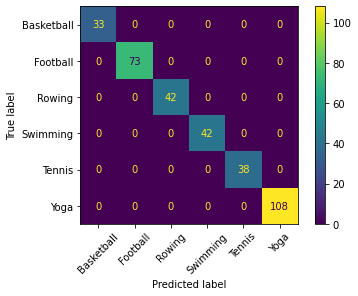

In [ ]:
show_confusion_matrix(xception, valid_data)

In [ ]:
xception.fit(valid_data, epochs=5, callbacks=[lr_reduction],
                   class_weight=class_weight)

# Testing Model

In [ ]:
pred = xception.predict(test_data).argmax(axis=1)

11/11 [==============================] - 6s 546ms/step


In [ ]:
files = np.array(sorted(os.listdir("/content/content/classed/Test")))

In [ ]:
files.reshape(-1,1).shape

(688, 1)

In [ ]:
sub = pd.DataFrame(files, columns=["image_name"])

In [ ]:
sub["label"] = pred

In [ ]:
sub.to_csv("pretrained_xc_97acc_aug.csv", index = False ,encoding='utf-8')

In [ ]:
!cp "/content/checkpoints/pretrained-xcep-e05-acc0.97.hdf5" "/content/drive/MyDrive/Edu/NN"